# Calculate phase dependent modulation of AP threshold poisson excitation and rhythmic inhibition with reversed targeting of inhibitory rhythms to dendrites

The simulations had either: 
1. Rhythmic inhibition at the dendrites (64 Hz) or soma (16 Hz) 
2. Poisson excitation at the soma and dendrites

Here we calculate voltage threshold for action potentials. These are stratified by:
1. Phase (peak or trough) of the inhibitory rhythm
2. Frequency of rhythm

The output of this script are...


In [1]:
import sys
sys.path.append('..') # have to do this for relative imports in jupyter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.load_spike_h5 import load_spike_h5
from src.load_v_h5 import load_v_h5
from src.load_axcurrent_csv import load_axcurrent_csv

## 1.0 Analysis parameters


### 1.1 Simulation constants and analysis windows

In [2]:
samps_per_ms = 10 
edges_v = np.arange(-80,-40,0.5)
edges_i = np.linspace(-3,3,160)
sim_win = [0, 1500000] # beginning and start points of simulation in samples

In [3]:
# Determines which axial currents are valid
seg_df = pd.read_csv('Z:\\DendOscSub\\DetailedSegmentsAxialR.csv')
seg_df = seg_df[['segmentID', 'Type', 'ParentSegID']]
soma_ids = seg_df[seg_df['Type']=='soma'].segmentID.values
soma_conn = seg_df[np.isin(seg_df['ParentSegID'],soma_ids)]
soma_conn = soma_conn[(soma_conn['Type']=='dend') | (soma_conn['Type']=='apic')]
soma_conn['pairname'] = soma_conn['ParentSegID'].map(lambda x: f'{x:5.0f}'.lstrip()) + '_to_' + soma_conn['segmentID'].map(str)
basal_pairs = soma_conn['pairname'][soma_conn['Type']=='dend'].values
apic_pairs = soma_conn['pairname'][soma_conn['Type']=='apic'].values

### 1.2 List files to be processed

In [4]:
# locate simulation files
root_16_dir = 'Z:\\DendOscSub\\output_16Hz_on_soma_dom_20p\\'
sim_16_dict = {'SimName': 'output_16Hz_on_soma_dom',
               'RootDir': root_16_dir,
               'CaFile': root_16_dir + 'output_16Hz_on_soma_dom_20p_ca.csv',
               'NaFile': root_16_dir + 'output_16Hz_on_soma_dom_20p_na.csv',
               'NMDAFile': root_16_dir + 'output_16Hz_on_soma_dom_20p_nmda.csv',
               'APFile': root_16_dir + 'spikes.h5',
               'InhProxFile': root_16_dir + 'prox_inh_stim_spikes.h5',
               'InhDistFile': root_16_dir + 'dist_inh_stim_spikes.h5', 
               'VMemFile': root_16_dir + 'v_report.h5',
               'AxCurrFile': root_16_dir + 'axial_currents.csv'}

root_64_dir = 'Z:\\DendOscSub\\output_64Hz_on_dends_dom_40p\\'
sim_64_dict = {'SimName': 'output_64Hz_on_dends',
               'RootDir': root_64_dir,
               'CaFile': root_64_dir + 'output_64Hz_on_dends_dom_40p_ca.csv',
               'NaFile': root_64_dir + 'output_64Hz_on_dends_dom_40p_na.csv',
               'NMDAFile': root_64_dir + 'output_64Hz_on_dends_dom_40p_nmda.csv',
               'APFile': root_64_dir + 'spikes.h5',
               'InhProxFile': root_64_dir + 'prox_inh_stim_spikes.h5',
               'InhDistFile': root_64_dir + 'dist_inh_stim_spikes.h5', 
               'VMemFile': root_64_dir + 'v_report.h5',
               'AxCurrFile': root_64_dir + 'axial_currents.csv'}

root_pois_dir = 'Z:\\DendOscSub\\output_allpoisson\\'
sim_pois_dict = {'SimName': 'output_allpoisson',
               'RootDir': root_pois_dir,
               'CaFile': root_pois_dir + 'output_64Hz_no_exc_mod_ca.csv',
               'NaFile': root_pois_dir + 'output_64Hz_no_exc_mod_na.csv',
               'NMDAFile': root_pois_dir + 'output_64Hz_no_exc_mod_nmda.csv',
               'APFile': root_pois_dir + 'spikes.h5',
               'VMemFile': root_pois_dir + 'v_report.h5',
               'AxCurrFile': root_pois_dir + 'axial_currents.csv'}



## 2.0 Phase binned probability of somatic spikes over membrane voltage

### 2.1 Generate phase series for each experiment

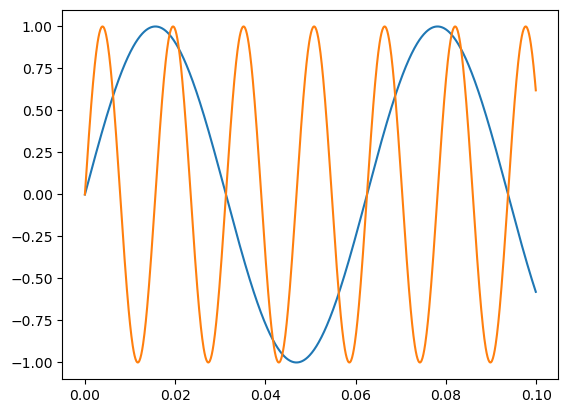

In [5]:
# generate phase time series for inhibitory afferents
t_ser = np.arange(sim_win[0], sim_win[1], 1) / 10000 # seconds
sin_16_ser = np.sin(t_ser*16*2*np.pi)
sin_64_ser = np.sin(t_ser*64*2*np.pi)

fig, ax = plt.subplots()
ax.plot(t_ser[0:1000],sin_16_ser[0:1000])
ax.plot(t_ser[0:1000],sin_64_ser[0:1000])
plt.show()

### 2.2 Calculate action potential threshold voltage

In [6]:
# probability of action potentials by membrane voltage
def ap_prob_func(spk, v, edges):
    null_hist = np.histogram(v, edges)
    spk_hist = np.histogram(v[spk-10], edges)
    spk_cum_prob = np.nancumsum(spk_hist[0]/null_hist[0])
    return {'null': null_hist[0], 'spk': spk_hist[0], 'prob': spk_cum_prob}

def thresh_files_func(sim_dict, sin_ser):
    spk_prob = {'v': {}, 'i_apic': {}, 'i_basal': {}}

    # split action potentials based on phase of rhythm
    spk_t = load_spike_h5(sim_dict['APFile'])
    p_inds = np.where(sin_ser >= 0)
    t_inds = np.where(sin_ser < 0)
    spk_t_p = np.intersect1d(spk_t, p_inds)
    spk_t_t = np.intersect1d(spk_t, t_inds)
    
    # load soma voltage
    mem_v = load_v_h5(sim_dict['VMemFile'], 0)

    # # load axial currents into soma
    # basal_i, apic_i = load_axcurrent_csv(sim_dict['AxCurrFile'], basal_pairs, apic_pairs)
    # basal_i = np.sum(basal_i, axis=1)
 
    # calculate action potential probability by voltage for each phase
    spk_prob['v']['p'] = ap_prob_func(spk_t_p, mem_v, edges_v)
    spk_prob['v']['t'] = ap_prob_func(spk_t_t, mem_v, edges_v)

    # membrane voltage distribution by phase
    spk_prob['v']['p']['dist'] = np.histogram(mem_v[p_inds], edges_v)[0]
    spk_prob['v']['t']['dist'] = np.histogram(mem_v[t_inds], edges_v)[0]

    # # calculate action potential probability by axial current for each phase
    # spk_prob['i_apic']['p'] = ap_prob_func(spk_t_p, apic_i, edges_i)
    # spk_prob['i_apic']['t'] = ap_prob_func(spk_t_t, apic_i, edges_i)
    # spk_prob['i_basal']['p'] = ap_prob_func(spk_t_p, basal_i, edges_i)
    # spk_prob['i_basal']['t'] = ap_prob_func(spk_t_t, basal_i, edges_i)   

    # # axial current distribution by phase
    # spk_prob['i_apic']['p']['dist'] = np.histogram(apic_i[p_inds], edges_i)[0]
    # spk_prob['i_apic']['t']['dist'] = np.histogram(apic_i[t_inds], edges_i)[0]
    # spk_prob['i_basal']['p']['dist'] = np.histogram(basal_i[p_inds], edges_i)[0]
    # spk_prob['i_basal']['t']['dist'] = np.histogram(basal_i[t_inds], edges_i)[0]

    return spk_prob

def thresh_files_pois_func(sim_dict):
    spk_prob = {'v': {}, 'i_apic': {}, 'i_basal': {}}

    # split action potentials based on phase of rhythm
    spk_t = load_spike_h5(sim_dict['APFile'])
   
    # load soma voltage
    mem_v = load_v_h5(sim_dict['VMemFile'], 0)

    # load axial currents into soma
    # basal_i, apic_i = load_axcurrent_csv(sim_dict['AxCurrFile'], basal_pairs, apic_pairs)
    # basal_i = np.sum(basal_i, axis=1)

    # calculate action potential probability by voltage
    spk_prob['v']['pois'] = ap_prob_func(spk_t, mem_v, edges_v)
   
    # membrane voltage distribution
    spk_prob['v']['pois']['dist'] = np.histogram(mem_v, edges_v)[0]

    # # calculate action potential probability by axial current
    # spk_prob['i_apic']['pois'] = ap_prob_func(spk_t, apic_i, edges_i)
    # spk_prob['i_basal']['pois'] = ap_prob_func(spk_t, basal_i, edges_i)
   
    # # axial current distribution
    # spk_prob['i_apic']['pois']['dist'] = np.histogram(apic_i, edges_i)[0]
    # spk_prob['i_basal']['pois']['dist'] = np.histogram(basal_i, edges_i)[0]
    return spk_prob

In [7]:
# process the 16 Hz distal dendritic inhibition simulation
ph16_prob = thresh_files_func(sim_16_dict, sin_16_ser)

# process the 64 Hz proximal dendritic/somatic inhibition simulation
ph64_prob = thresh_files_func(sim_64_dict, sin_64_ser)

# process the poisson inhibition simulation
pois_prob = thresh_files_pois_func(sim_pois_dict)

C:\Users\dbh60\AppData\Local\Temp\ipykernel_17832\3541212129.py:5: RuntimeWarning: invalid value encountered in divide
  spk_cum_prob = np.nancumsum(spk_hist[0]/null_hist[0])


### 2.3 Plots

In [8]:
# plotting functions
# set meas to 'v' for voltage, and 'i' for current
def ap_prob_ph_plot(ph_prob, ax, meas='v'):
        if meas=='v':
                edges = edges_v[:-1]
        elif meas=='i_apic' or meas=='i_basal':
                edges = edges_i[:-1]
        
        ax.plot(edges, ph_prob[meas]['p']['prob']/np.max(ph_prob[meas]['p']['prob']),color='r')
        ax.plot(edges, ph_prob[meas]['t']['prob']/np.max(ph_prob[meas]['t']['prob']),color='b')
        ax.plot(edges, pois_prob[meas]['pois']['prob']/np.max(pois_prob[meas]['pois']['prob']),color='k')

def meas_prob_ph_plot(ph_prob, ax, meas='v'):
        if meas=='v':
                edges = edges_v[:-1]
        elif meas=='i_apic' or meas=='i_basal':
                edges = edges_i[:-1]

        ax.plot(edges, ph_prob[meas]['p']['dist']/np.max(ph_prob[meas]['p']['dist']),color='r')
        ax.plot(edges, ph_prob[meas]['t']['dist']/np.max(ph_prob[meas]['t']['dist']),color='b')
        ax.plot(edges, pois_prob[meas]['pois']['dist']/np.max(pois_prob[meas]['pois']['dist']),color='k')

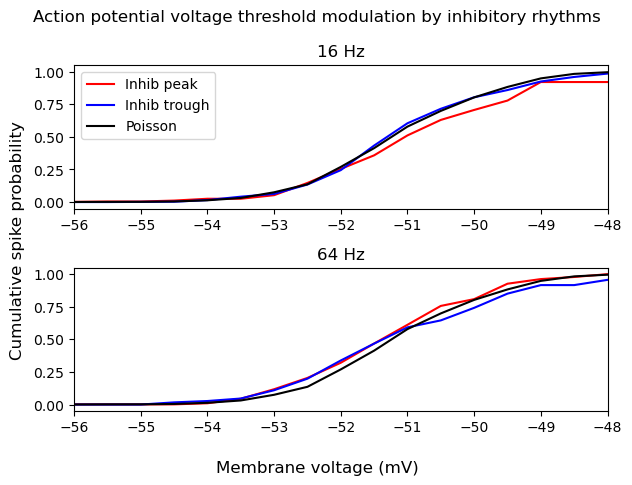

In [9]:
# Action potential probabilities by membrane voltage and phase
fig, ax = plt.subplots(2,1,sharey=True)
ap_prob_ph_plot(ph16_prob, ax[0])
ap_prob_ph_plot(ph64_prob, ax[1])
ax[0].set_title('16 Hz')
ax[1].set_title('64 Hz')
ax[0].set_xlim([-56, -48])
ax[1].set_xlim([-56, -48])
fig.suptitle('Action potential voltage threshold modulation by inhibitory rhythms')
fig.supxlabel('Membrane voltage (mV)')
fig.supylabel('Cumulative spike probability')
ax[0].legend(('Inhib peak', 'Inhib trough', 'Poisson'))
plt.tight_layout()
plt.savefig('../figures/APVoltDependenceRev.pdf')


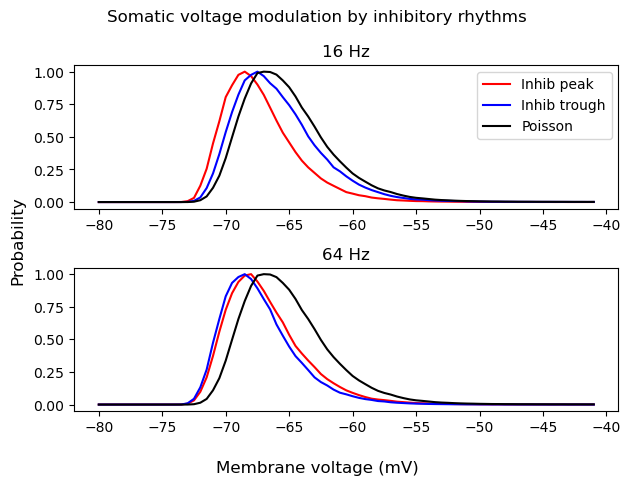

<Figure size 640x480 with 0 Axes>

In [10]:
# Membrane voltage by phase
fig, ax = plt.subplots(2,1,sharey=True)
meas_prob_ph_plot(ph16_prob, ax[0])
meas_prob_ph_plot(ph64_prob, ax[1])
ax[0].set_title('16 Hz')
ax[1].set_title('64 Hz')
fig.suptitle('Somatic voltage modulation by inhibitory rhythms')
fig.supxlabel('Membrane voltage (mV)')
fig.supylabel('Probability')
ax[0].legend(('Inhib peak', 'Inhib trough', 'Poisson'))
plt.tight_layout()
plt.show()
plt.savefig('../figures/MemVoltDistributionRev.pdf')

In [11]:
# # Action potential probabilities by basal dendrite axial current and phase
# fig, ax = plt.subplots(2,1,sharey=True)
# ap_prob_ph_plot(ph16_prob, ax[0], meas='i_basal')
# ap_prob_ph_plot(ph64_prob, ax[1], meas='i_basal')
# ax[0].set_title('16 Hz')
# ax[1].set_title('64 Hz')
# fig.suptitle('Action potential basal current threshold modulation by inhibitory rhythms')
# fig.supxlabel('Axial current (nA?)')
# fig.supylabel('Cumulative spike probability')
# ax[0].legend(('Inhib peak', 'Inhib trough', 'Poisson'))
# plt.tight_layout()
# plt.show()

In [12]:
# # Action potential probabilities by apical dendrite axial current and phase
# fig, ax = plt.subplots(2,1,sharey=True)
# ap_prob_ph_plot(ph16_prob, ax[0], meas='i_apic')
# ap_prob_ph_plot(ph64_prob, ax[1], meas='i_apic')
# ax[0].set_title('16 Hz')
# ax[1].set_title('64 Hz')
# fig.suptitle('Action potential apical current threshold modulation by inhibitory rhythms')
# fig.supxlabel('Axial current (nA?)')
# fig.supylabel('Cumulative spike probability')
# ax[0].legend(('Inhib peak', 'Inhib trough', 'Poisson'))
# plt.tight_layout()
# plt.savefig('../figures/APAxialApicDepend.png')

In [13]:
# # Basal dendrite axial current modulation by phase
# fig, ax = plt.subplots(2,1,sharey=True)
# meas_prob_ph_plot(ph16_prob, ax[0], meas='i_basal')
# meas_prob_ph_plot(ph64_prob, ax[1], meas='i_basal')
# ax[0].set_title('16 Hz')
# ax[1].set_title('64 Hz')
# fig.suptitle('Basal dendrite axial current modulation by inhibitory rhythms')
# fig.supxlabel('Axial current (nA?)')
# fig.supylabel('Probability')
# ax[0].legend(('Inhib peak', 'Inhib trough', 'Poisson'))
# plt.tight_layout()
# plt.show()

In [14]:
# # Apical dendrite axial current modulation by phase
# fig, ax = plt.subplots(2,1,sharey=True)
# meas_prob_ph_plot(ph16_prob, ax[0], meas='i_apic')
# meas_prob_ph_plot(ph64_prob, ax[1], meas='i_apic')
# ax[0].set_title('16 Hz')
# ax[1].set_title('64 Hz')
# fig.suptitle('Apical dendrite axial current modulation by inhibitory rhythms')
# fig.supxlabel('Axial current (nA?)')
# fig.supylabel('Probability')
# ax[0].legend(('Inhib peak', 'Inhib trough', 'Poisson'))
# plt.tight_layout()
# plt.show()